# ResOpsPT: climatic indices from EMO1
***

**_Autor:_** Chus Casado Rodríguez<br>
**_Fecha:_** 04-04-2025<br>

**Introduction:**<br>
This notebook creates the climatic indices for the catchments of the reservoirs in the ResOpsPT dataset using as reference the EMO-1 (European Meteorological Observations) dataset.

The inputs are the point shapefile of reservoirs in the dataset, and the areal meteorological time series in the catchmetns of those reservoirs. Producing those areal time series takes several steps:

1. Run the `lfcoords` tool to find the best location of the reservoirs in the LISFLOOD grid.
2. Run the `cutmaps` tool with the relocated points to define the catchments.
3. Run the `catchmaps` tool to compute the catchment average of the EMO-1 dataset.

The output is a CSV file (_climate_indices.csv_) with catchment characteristics like average precipitation, average temperature, average evapotranspiration, seasonality, etc.

In [2]:
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import xarray as xr
import geopandas as gpd
from tqdm.auto import tqdm

from lisfloodreservoirs.utils.plots import plot_attributes
from lisfloodreservoirs.utils import DatasetConfig
from lisfloodreservoirs.utils.utils import duration_precip_indices

## Configuration

In [6]:
cfg = DatasetConfig('config_dataset.yml')

PATH_METEO = cfg.PATH_RESOPS / 'ancillary' / 'catchstats'
PATH_PLOTS = cfg.PATH_ATTRS / 'plots'
PATH_PLOTS.mkdir(parents=False, exist_ok=True)

meteo_variables = {'pr': 'precip', 'ta': 'temp', 'e0': 'pet'}

print(f'Attributes will be saved in {cfg.PATH_ATTRS}')

Attributes will be saved in Z:\nahaUsers\casadje\datasets\reservoirs\ResOpsPT\v1.0\attributes


## Data

### Reservoirs

In [4]:
# load reservoir shapefile
reservoirs = gpd.read_file(cfg.PATH_RESOPS / 'GIS' / 'reservoirs_HDMS+GRAND.shp')
# remove those without associated GRanD ID
reservoirs = reservoirs[reservoirs.GRAND_ID.notnull()]
reservoirs.GRAND_ID = reservoirs.GRAND_ID.astype(int)
reservoirs.set_index('GRAND_ID', drop=True, inplace=True)

print('HDMS')
print('-----')
print('No. reservoirs:\t{0}\nNo. attributes:\t{1}\n'.format(*reservoirs.shape))

HDMS
-----
No. reservoirs:	17
No. attributes:	29



### Meteorology

In [7]:
# load areal meteo time series
meteo = {}
variables = [item.stem for item in PATH_METEO.glob('*') if item.is_dir()]
for var in tqdm(variables):
    da = xr.open_mfdataset(f'{PATH_METEO}/{var}/*.nc')[f'{var}_mean'].compute()
    da.name = var
    da = da.rename({'id': 'ID'})
    meteo[var] = da
meteo = xr.Dataset(meteo)
meteo = meteo.rename(meteo_variables)

# compute precipitation as snowfall
meteo['snow'] = meteo['precip'].where(meteo['temp'] > 1, 0)

  0%|          | 0/3 [00:00<?, ?it/s]

## Attributes

In [8]:
# average of all meteo variables
attrs = meteo.mean('time').to_pandas()
attrs.columns = [f'{col}_mean' for col in attrs.columns]
attrs.index.name = 'GRAND_ID'

# indices
attrs['aridity'] = attrs.precip_mean / attrs.pet_mean
attrs['frac_snow'] = attrs.snow_mean / attrs.precip_mean
attrs['moisture_index'] = attrs.precip_mean - attrs.pet_mean
precip_monthly = meteo['precip'].resample({'time': '1M'}).sum().groupby('time.month').mean()
precip_annual = meteo['precip'].resample({'time': 'A'}).sum().mean('time')
attrs['seasonality'] = ((precip_monthly.max('month') - precip_monthly.min('month')) / precip_annual).to_pandas()

# high and dry precipitation indices
precip_extremes = {
    'high': 20, # mm
    'low': 1 # mm
}
for key, value in precip_extremes.items():
    if key == 'high':
        mask_precip = meteo['precip'] > value
    elif key == 'low':
        mask_precip = meteo['precip'] < value
    attrs[f'{key}_precip_freq'] = mask_precip.sum('time') / len(meteo.time)
    attrs[f'{key}_precip_dur'] = duration_precip_indices(mask_precip.to_pandas())

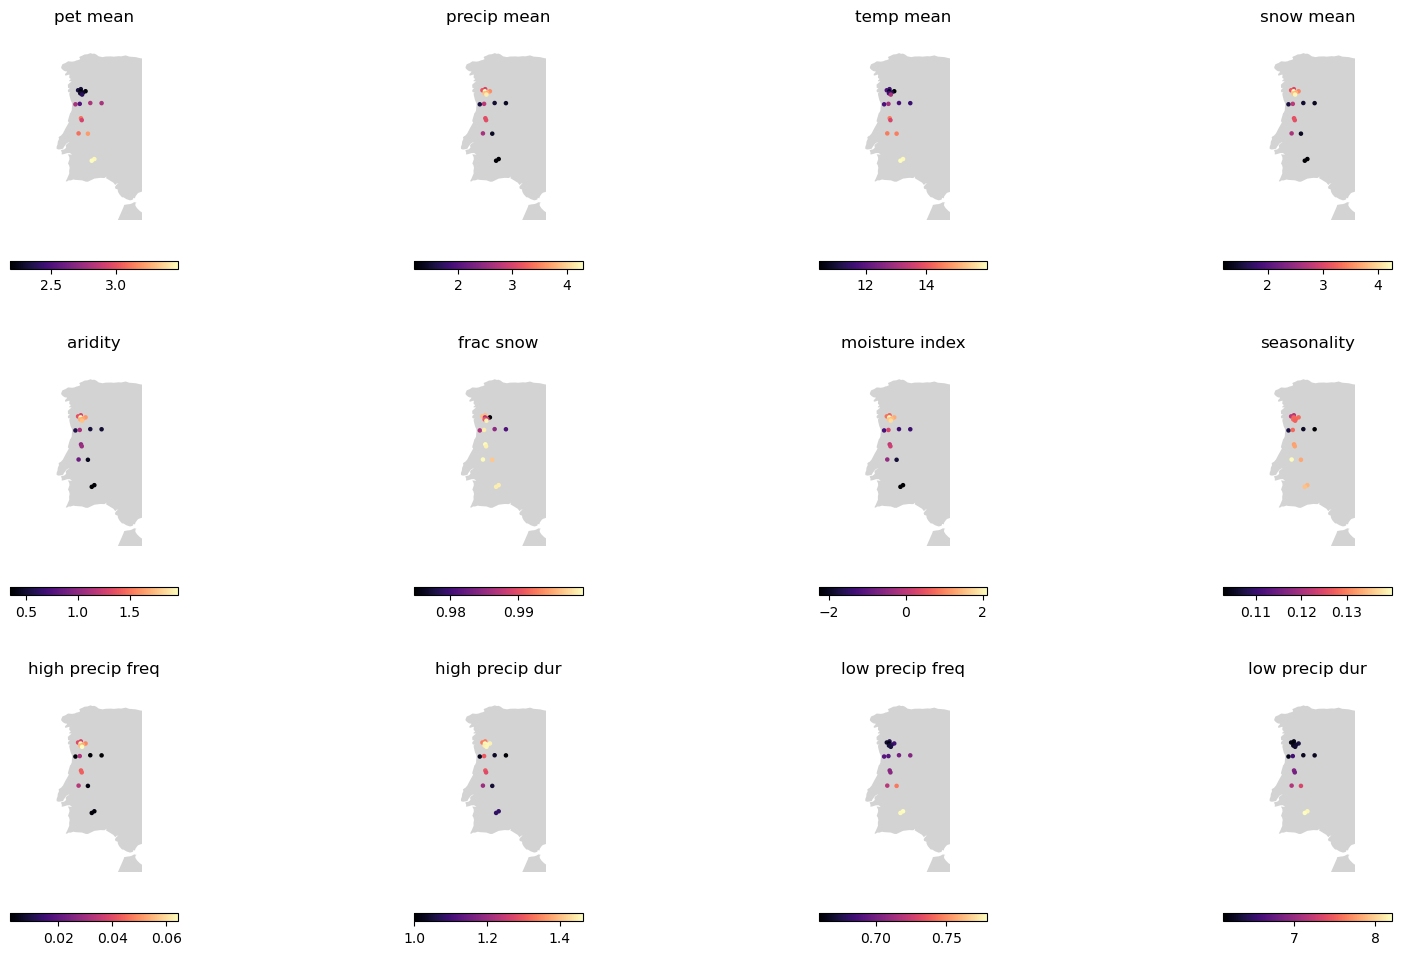

In [12]:
# plot attributes
r = 5
extent = [np.floor(reservoirs.geometry.x.min() / r) * r, np.ceil(reservoirs.geometry.x.max() / r) * r,
          np.floor(reservoirs.geometry.y.min() / r) * r, np.ceil(reservoirs.geometry.y.max() / r) * r]
plot_attributes(
    attrs,
    reservoirs.geometry.x,
    reservoirs.geometry.y,
    ncols=4,
    extent=extent,
    save=PATH_PLOTS / f'maps_climate.jpg'
)

In [13]:
# export
attrs.to_csv(cfg.PATH_ATTRS / 'climate_indices.csv', float_format='%.6f')